In [9]:
notebook_mode = True
viz_mode = False

In [10]:
import os
import json
import argparse
import time

import numpy as np

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt

import networkx as nx
from sklearn.utils.class_weight import compute_class_weight

from tensorboardX import SummaryWriter
from fastprogress import master_bar, progress_bar

# Remove warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore', SparseEfficiencyWarning)

from config import *
from utils.graph_utils import *
from utils.google_tsp_reader import GoogleTSPReader, VariableTSPReader
from utils.plot_utils import *
from models.gcn_model import ResidualGatedGCNModel
from utils.model_utils import *

In [11]:
if notebook_mode == True:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('png')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load configurations

In [12]:
if notebook_mode==False:
    parser = argparse.ArgumentParser(description='gcn_tsp_parser')
    parser.add_argument('-c','--config', type=str, default="configs/euc_2d.json")
    args = parser.parse_args()
    config_path = args.config
elif viz_mode == True:
    config_path = "logs/tsp100/config.json"
else:
    config_path = "configs/geo_ran.json"

config = get_config(config_path)
print("Loaded {}:\n{}".format(config_path, config))

Loaded configs/geo_ran.json:
{'expt_name': 'geo_all_random', 'gpu_id': '0', 'train_filepath': './data/new-generated/geo_train.json', 'val_filepath': './data/new-generated/geo_val.json', 'test_filepath': './data/new-generated/geo_test.json', 'num_nodes': 10, 'num_neighbors': 5, 'node_dim': 2, 'voc_nodes_in': 2, 'voc_nodes_out': 2, 'voc_edges_in': 3, 'voc_edges_out': 2, 'beam_size': 1280, 'hidden_dim': 128, 'num_layers': 12, 'mlp_layers': 3, 'aggregation': 'mean', 'max_epochs': 100, 'val_every': 5, 'test_every': 50, 'batch_size': 20, 'batches_per_epoch': 500, 'accumulation_steps': 1, 'learning_rate': 0.001, 'decay_rate': 1.01, 'iteration_mode': 'random', 'knn_ratio': 0.2, 'metric': 'GEO'}


In [13]:
# Over-ride config params (for viz_mode)
if viz_mode==True:
    config.gpu_id = "0"
    config.batch_size = 1
    config.accumulation_steps = 1
    config.beam_size = 1280
    
    # Uncomment below to evaluate generalization to variable sizes in viz_mode
#     config.num_nodes = 50
#     config.knn_ratio = 20
#     config.train_filepath = f"./data/tsp{config.num_nodes}_train_concorde.txt"
#     config.val_filepath = f"./data/tsp{config.num_nodes}_val_concorde.txt"
#     config.test_filepath = f"./data/tsp{config.num_nodes}_test_concorde.txt"

# Configure GPU options

In [14]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(config.gpu_id)  

In [15]:
if torch.cuda.is_available():
    print("CUDA available, using GPU ID {}".format(config.gpu_id))
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print("CUDA not available")
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)

CUDA available, using GPU ID 0


# Test data loading

Available N sizes and batch counts:
  N = 10: 45 batches
  N = 20: 43 batches
  N = 30: 45 batches
  N = 40: 44 batches
  N = 50: 43 batches
  N = 60: 44 batches
  N = 70: 43 batches
  N = 80: 44 batches
  N = 90: 44 batches
  N = 100: 45 batches
Batch generation took: 0.004 sec
Batch node count (N): 20
edges: (20, 20, 20)
edges_values: (20, 20, 20)
edges_targets: (20, 20, 20)
nodes: (20, 20)
nodes_target: (20, 20)
nodes_coord: (20, 20, 2)
tour_nodes: (20, 20)
tour_len: (20,)


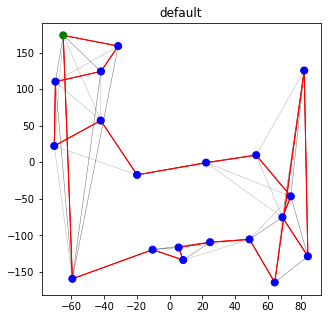

In [16]:
if notebook_mode:
    batch_size = config.batch_size
    train_filepath = config.train_filepath

    # Agora o reader não precisa de num_nodes nem knn_ratio
    dataset = VariableTSPReader(config.train_filepath, batch_size,  knn_ratio=config.knn_ratio, iteration_mode=config.iteration_mode, metric=config.metric)

    # Conta quantos batches existem por tamanho
    print("Available N sizes and batch counts:")
    for N in dataset.sizes:
        print(f"  N = {N}: {dataset.num_batches[N]} batches")

    # Gera um batch (pode ser N diferente a cada execução)
    t = time.time()
    batch = next(iter(dataset))
    print("Batch generation took: {:.3f} sec".format(time.time() - t))

    # Descobre automaticamente o N do batch
    num_nodes = batch.nodes.shape[1]
    print(f"Batch node count (N): {num_nodes}")

    # Print shapes
    print("edges:", batch.edges.shape)
    print("edges_values:", batch.edges_values.shape)
    print("edges_targets:", batch.edges_target.shape)
    print("nodes:", batch.nodes.shape)
    print("nodes_target:", batch.nodes_target.shape)
    print("nodes_coord:", batch.nodes_coord.shape)
    print("tour_nodes:", batch.tour_nodes.shape)
    print("tour_len:", batch.tour_len.shape)

    # Plotar um exemplo da batch
    idx = 0  # escolha outro índice se quiser
    f = plt.figure(figsize=(5, 5))
    a = f.add_subplot(111)
    plot_tsp(
        a,
        batch.nodes_coord[idx],
        batch.edges[idx],
        batch.edges_values[idx],
        batch.edges_target[idx],
    )


In [17]:
import itertools
import numpy as np

def tour_cost(tour, W):
    cost = 0
    for i in range(len(tour) - 1):
        cost += W[tour[i], tour[i + 1]]
    cost += W[tour[-1], tour[0]]
    return cost


def brute_force_tsp(W):
    N = W.shape[0]
    best_cost = np.inf
    best_tour = None

    # fixa nó 0 para eliminar rotações
    for perm in itertools.permutations(range(1, N)):
        tour = (0,) + perm
        cost = tour_cost(tour, W)

        if cost < best_cost:
            best_cost = cost
            best_tour = tour

    return best_tour, best_cost


In [18]:
# força pegar batch de N=10
N = 10
assert N in dataset.sizes, "Não existe N=10 no dataset"

inst_list = dataset.by_size[N]
B = dataset.batch_size

batch_10 = dataset.process_batch(inst_list[:B], N)


# Instantiate model

In [25]:
if notebook_mode == True:
    # Instantiate the network
    net = nn.DataParallel(ResidualGatedGCNModel(config, dtypeFloat, dtypeLong))
    if torch.cuda.is_available():
        net.cuda()
    print(net)

    # Compute number of network parameters
    nb_param = 0
    for param in net.parameters():
        nb_param += np.prod(list(param.data.size()))
    print('Number of parameters:', nb_param)
    
    # Define optimizer
    learning_rate = config.learning_rate
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    print(optimizer)

DataParallel(
  (module): ResidualGatedGCNModel(
    (nodes_coord_embedding): Linear(in_features=2, out_features=128, bias=False)
    (edges_values_embedding): Linear(in_features=1, out_features=64, bias=False)
    (edges_embedding): Embedding(3, 64)
    (gcn_layers): ModuleList(
      (0): ResidualGatedGCNLayer(
        (node_feat): NodeFeatures(
          (U): Linear(in_features=128, out_features=128, bias=True)
          (V): Linear(in_features=128, out_features=128, bias=True)
        )
        (edge_feat): EdgeFeatures(
          (U): Linear(in_features=128, out_features=128, bias=True)
          (V): Linear(in_features=128, out_features=128, bias=True)
        )
        (bn_node): BatchNormNode(
          (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
        (bn_edge): BatchNormEdge(
          (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
      )
      (1): Resi

## Test forward pass

In [26]:
if notebook_mode == True and viz_mode == False:
    # Generate a batch of TSPs
    num_nodes = config.num_nodes
    knn_ratio = config.knn_ratio
    batch_size = config.batch_size
    train_filepath = config.train_filepath

    dataset = iter(VariableTSPReader(train_filepath, batch_size,  knn_ratio=config.knn_ratio, metric=config.metric))
    batch = next(dataset)

    # Convert batch to torch Variables
    x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
    x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
    x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
    x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
    y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
    y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)
    
    # Compute class weights
    edge_labels = y_edges.cpu().numpy().flatten()
    edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
    print("Class weights: {}".format(edge_cw))
        
    # Forward pass
    y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
    loss = loss.mean()
    print("Output size: {}".format(y_preds.size()))
    print("Loss value:", loss)

Class weights: [0.625 2.5  ]
Output size: torch.Size([20, 10, 10, 2])
Loss value: tensor(1020.9270, device='cuda:0', grad_fn=<MeanBackward0>)


## Test backward pass

In [27]:
if notebook_mode == True and viz_mode == False:
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    
    # Optimizer step
    optimizer.step()
    
    # Compute error metrics 
    err_edges, err_tour, err_tsp, tour_err_idx, tsp_err_idx = edge_error(y_preds, y_edges, x_edges)
    print("Edge error: {:.3f}\nTour error: {:.3f}\nTSP error: {:.3f}".format(err_edges, err_tour, err_tsp))
    
    # Compute mean predicted and groundtruth tour length
    pred_tour_len = mean_tour_len_edges(x_edges_values, y_preds)
    gt_tour_len = np.mean(batch.tour_len) 
    print("Predicted tour length: {:.3f}\nGroundtruth tour length: {:.3f}".format(pred_tour_len, gt_tour_len))

Edge error: 85.625
Tour error: 100.000
TSP error: 100.000
Predicted tour length: 5.000
Groundtruth tour length: 54461.600


## Training Loop (one epoch)

In [ ]:
def train_one_epoch(net, optimizer, config, master_bar):
    # Set training mode
    net.train()

    # Assign parameters
    num_nodes = config.num_nodes
    knn_ratio = config.knn_ratio
    batch_size = config.batch_size
    batches_per_epoch = config.batches_per_epoch
    accumulation_steps = config.accumulation_steps
    train_filepath = config.train_filepath
    loss_by_size = {} 
    # Load TSP data
    dataset = VariableTSPReader(train_filepath, batch_size,  knn_ratio=config.knn_ratio, metric=config.metric)
    if batches_per_epoch != -1:
        batches_per_epoch = min(batches_per_epoch, dataset.max_iter)
    else:
        batches_per_epoch = dataset.max_iter

    # Convert dataset to iterable
    dataset = iter(dataset)
    
    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    # running_err_edges = 0.0
    # running_err_tour = 0.0
    # running_err_tsp = 0.0
    running_pred_tour_len = 0.0
    running_gt_tour_len = 0.0
    running_nb_data = 0
    running_nb_batch = 0

    start_epoch = time.time()
    for batch_num in progress_bar(range(batches_per_epoch), parent=master_bar):
        # Generate a batch of TSPs
        try:
            batch = next(dataset)
        except StopIteration:
            break

        # Convert batch to torch Variables
        x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
        x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
        x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
        x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
        y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
        y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)
        
        # Compute class weights (if uncomputed)
        edge_labels = y_edges.cpu().numpy().flatten()
        edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
        
        # Forward pass
        y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
        loss = loss.mean()  # Take mean of loss across multiple GPUs
        loss = loss / accumulation_steps  # Scale loss by accumulation steps
        loss.backward()

        N = x_nodes.shape[1]   # número de nós deste batch
        if N not in loss_by_size:
            loss_by_size[N] = []

        loss_by_size[N].append(loss.item())
        # Backward pass
        if (batch_num+1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # Compute error metrics and mean tour lengths
        # err_edges, err_tour, err_tsp, tour_err_idx, tsp_err_idx = edge_error(y_preds, y_edges, x_edges)
        pred_tour_len = mean_tour_len_edges(x_edges_values, y_preds)
        gt_tour_len = np.mean(batch.tour_len)

        # Update running data
        running_nb_data += batch_size
        running_loss += batch_size* loss.data.item()* accumulation_steps  # Re-scale loss
        # running_err_edges += batch_size* err_edges
        # running_err_tour += batch_size* err_tour
        # running_err_tsp += batch_size* err_tsp
        running_pred_tour_len += batch_size* pred_tour_len
        running_gt_tour_len += batch_size* gt_tour_len
        running_nb_batch += 1
        
        # Log intermediate statistics
        result = ('loss:{loss:.4f} pred_tour_len:{pred_tour_len:.3f} gt_tour_len:{gt_tour_len:.3f}'.format(
            loss=running_loss/running_nb_data,
            pred_tour_len=running_pred_tour_len/running_nb_data,
            gt_tour_len=running_gt_tour_len/running_nb_data))
        master_bar.child.comment = result

    # Compute statistics for full epoch
    loss = running_loss/ running_nb_data
    err_edges = 0 # running_err_edges/ running_nb_data
    err_tour = 0 # running_err_tour/ running_nb_data
    err_tsp = 0 # running_err_tsp/ running_nb_data
    pred_tour_len = running_pred_tour_len/ running_nb_data
    gt_tour_len = running_gt_tour_len/ running_nb_data

    return time.time()-start_epoch, loss, err_edges, err_tour, err_tsp, pred_tour_len, gt_tour_len, loss_by_size

def metrics_to_str(epoch, time, learning_rate, loss, err_edges, err_tour, err_tsp,
                   pred_tour_len, gt_tour_len, loss_by_size=None):

    result = (
        'epoch:{epoch:0>2d}\t'
        'time:{time:.1f}h\t'
        'lr:{learning_rate:.2e}\t'
        'loss:{loss:.4f}\t'
        'pred_tour_len:{pred_tour_len:.3f}\t'
        'gt_tour_len:{gt_tour_len:.3f}'
    ).format(
        epoch=epoch,
        time=time/3600,
        learning_rate=learning_rate,
        loss=loss,
        pred_tour_len=pred_tour_len,
        gt_tour_len=gt_tour_len
    )

    # === FIX: se o valor for lista → tira a média ===
    if loss_by_size is not None:
        parts = []
        for N in sorted(loss_by_size.keys()):
            val = loss_by_size[N]
            if isinstance(val, list):
                if len(val) > 0:
                    v = sum(val)/len(val)
                else:
                    v = float('nan')
            else:
                v = float(val)

            parts.append(f"N{N}:{v:.4f}")

        result += "\t(loss_by_size: " + " ".join(parts) + ")"

    return result


In [15]:
if notebook_mode==True and viz_mode==False:
    epoch_bar = master_bar(range(1))
    for epoch in epoch_bar:

        train_time, train_loss, train_err_edges, train_err_tour, train_err_tsp, \
        train_pred_tour_len, train_gt_tour_len, N = \
            train_one_epoch(net, optimizer, config, epoch_bar)

        epoch_bar.write(
            't: ' + metrics_to_str(epoch, train_time, learning_rate, train_loss,
                                   train_err_edges, train_err_tour, train_err_tsp,
                                   train_pred_tour_len, train_gt_tour_len, N)
        )


# Evaluation Loop (for validation and test sets)

In [20]:
def test(net, config, master_bar, mode='test'):
    # Set evaluation mode
    net.eval()

    # Assign parameters
    # num_nodes = config.num_nodes
    knn_ratio = config.knn_ratio
    batch_size = config.batch_size
    batches_per_epoch = config.batches_per_epoch
    beam_size = config.beam_size
    val_filepath = config.val_filepath
    test_filepath = config.test_filepath

    # Load TSP data
    if mode == 'val':
        dataset = VariableTSPReader(val_filepath, batch_size,  knn_ratio=config.knn_ratio, metric=config.metric)
    elif mode == 'test':
        dataset = VariableTSPReader(test_filepath, batch_size,  knn_ratio=config.knn_ratio,metric=config.metric)
    batches_per_epoch = dataset.max_iter

    # Convert dataset to iterable
    dataset = iter(dataset)
    
    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    # running_err_edges = 0.0
    # running_err_tour = 0.0
    # running_err_tsp = 0.0
    running_pred_tour_len = 0.0
    running_gt_tour_len = 0.0
    running_nb_data = 0
    running_nb_batch = 0
    
    with torch.no_grad():
        start_test = time.time()
        for batch_num in progress_bar(range(batches_per_epoch), parent=master_bar):
            # Generate a batch of TSPs
            try:
                batch = next(dataset)
            except StopIteration:
                break

            # Convert batch to torch Variables
            x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
            x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
            x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
            x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
            y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
            y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)
            
            num_nodes = batch.nodes.shape[1]


            # Compute class weights (if uncomputed)
            edge_labels = y_edges.cpu().numpy().flatten()
            edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)

            # Forward pass
            y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
            loss = loss.mean()  # Take mean of loss across multiple GPUs

            # Compute error metrics
            # err_edges, err_tour, err_tsp, tour_err_idx, tsp_err_idx = edge_error(y_preds, y_edges, x_edges)

     

            # Get batch beamsearch tour prediction
            if mode == 'val':  # Validation: faster 'vanilla' beamsearch
                bs_nodes = beamsearch_tour_nodes(
                    y_preds, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')
            elif mode == 'test':  # Testing: beamsearch with shortest tour heuristic 
                bs_nodes = beamsearch_tour_nodes_shortest(
                    y_preds, x_edges_values, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')
            
            # Compute mean tour length
            pred_tour_len = mean_tour_len_nodes(x_edges_values, bs_nodes)
            gt_tour_len = np.mean(batch.tour_len)

            # Update running data
            running_nb_data += batch_size
            running_loss += batch_size* loss.data.item()
            # running_err_edges += batch_size* err_edges
            # running_err_tour += batch_size* err_tour
            # running_err_tsp += batch_size* err_tsp
            running_pred_tour_len += batch_size* pred_tour_len
            running_gt_tour_len += batch_size* gt_tour_len
            running_nb_batch += 1

            # Log intermediate statistics
            result = ('loss:{loss:.4f} pred_tour_len:{pred_tour_len:.3f} gt_tour_len:{gt_tour_len:.3f}'.format(
                loss=running_loss/running_nb_data,
                pred_tour_len=running_pred_tour_len/running_nb_data,
                gt_tour_len=running_gt_tour_len/running_nb_data))
            master_bar.child.comment = result

    # Compute statistics for full epoch
    loss = running_loss/ running_nb_data
    err_edges = 0 # running_err_edges/ running_nb_data
    err_tour = 0 # running_err_tour/ running_nb_data
    err_tsp = 0 # running_err_tsp/ running_nb_data
    pred_tour_len = running_pred_tour_len/ running_nb_data
    gt_tour_len = running_gt_tour_len/ running_nb_data

    return time.time()-start_test, loss, err_edges, err_tour, err_tsp, pred_tour_len, gt_tour_len

In [46]:
if notebook_mode==True and viz_mode==False:
    epoch_bar = master_bar(range(1))
    for epoch in epoch_bar:
        # Validation
        val_time, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len = test(net, config, epoch_bar, mode='val')
        epoch_bar.write('v: ' + metrics_to_str(epoch, val_time, learning_rate, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len))
        # Testing
        test_time, test_loss, test_err_edges, test_err_tour, test_err_tsp, test_pred_tour_len, test_gt_tour_len = test(net, config, epoch_bar, mode='test')
        epoch_bar.write('T: ' + metrics_to_str(epoch, test_time, learning_rate, test_loss, test_err_edges, test_err_tour, test_err_tsp, test_pred_tour_len, test_gt_tour_len))

# Run full training pipeline 

In [21]:
def main(config):
    # Instantiate the network
    net = nn.DataParallel(ResidualGatedGCNModel(config, dtypeFloat, dtypeLong))
    if torch.cuda.is_available():
        net.cuda()
    print(net)

    # Compute number of network parameters
    nb_param = 0
    for param in net.parameters():
        nb_param += np.prod(list(param.data.size()))
    print('Number of parameters:', nb_param)

    # Create log directory
    log_dir = f"./logs/{config.expt_name}/"
    os.makedirs(log_dir, exist_ok=True)
    json.dump(config, open(f"{log_dir}/config.json", "w"), indent=4)
    writer = SummaryWriter(log_dir)

    # Training parameters
    max_epochs = config.max_epochs
    val_every = config.val_every
    test_every = config.test_every
    accumulation_steps = config.accumulation_steps
    learning_rate = config.learning_rate
    decay_rate = config.decay_rate

    val_loss_old = 1e6
    best_pred_tour_len = 1e6  # For saving checkpoints

    # Define optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    print(optimizer)


    patience = 5   # quantos epochs sem melhorar antes de parar
    patience_counter = 0


    # -------------------------------
    # NEW: store epoch-wise metrics
    # -------------------------------
    history = {
        "train_loss": [],
        "val_loss": [],
        "test_loss": [],
        "train_loss_by_size": [],   # list of dicts
    }

    epoch_bar = master_bar(range(max_epochs))

    for epoch in epoch_bar:
        writer.add_scalar('learning_rate', learning_rate, epoch)

        # -------------------------
        # TRAIN
        # -------------------------
        (train_time, train_loss, train_err_edges, train_err_tour, 
         train_err_tsp, train_pred_tour_len, train_gt_tour_len, 
         loss_by_size) = train_one_epoch(net, optimizer, config, epoch_bar)

        # save for later export
        history["train_loss"].append(float(train_loss))
        epoch_size_means = {
            N: float(sum(vals)/len(vals)) for N, vals in loss_by_size.items()
        }

        history["train_loss_by_size"].append(epoch_size_means)

        epoch_bar.write(
            't: ' + metrics_to_str(
                epoch, train_time, learning_rate, train_loss,
                train_err_edges, train_err_tour, train_err_tsp,
                train_pred_tour_len, train_gt_tour_len, loss_by_size
            )
        )

        writer.add_scalar('loss/train_loss', train_loss, epoch)
        writer.add_scalar('pred_tour_len/train_pred_tour_len', train_pred_tour_len, epoch)
        writer.add_scalar('optimality_gap/train_opt_gap', train_pred_tour_len/train_gt_tour_len - 1, epoch)

        # -------------------------
        # VALIDATION
        # -------------------------
        if epoch % val_every == 0 or epoch == max_epochs - 1:

            (val_time, val_loss, val_err_edges, val_err_tour,
             val_err_tsp, val_pred_tour_len, val_gt_tour_len) = test(net, config, epoch_bar, mode='val')

            history["val_loss"].append(float(val_loss))

            epoch_bar.write(
                'v: ' + metrics_to_str(
                    epoch, val_time, learning_rate, val_loss,
                    val_err_edges, val_err_tour, val_err_tsp,
                    val_pred_tour_len, val_gt_tour_len
                )
            )

            writer.add_scalar('loss/val_loss', val_loss, epoch)

            # Save checkpoint if improved
            if val_pred_tour_len < best_val_pred_tour_len:
                best_val_pred_tour_len = float(val_pred_tour_len)
                patience_counter = 0

                torch.save({
                    "epoch": epoch,
                    "model_state_dict": net.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_pred_tour_len': val_pred_tour_len,
                    'val_gt_tour_len': val_gt_tour_len,
                    'val_opt_gap': val_pred_tour_len / val_gt_tour_len - 1,
                }, os.path.join(log_dir, "best_val_checkpoint.tar"))
            else:
                patience_counter += 1

            # Update LR
            if val_loss > 0.99 * val_loss_old:
                learning_rate /= decay_rate
                optimizer = update_learning_rate(optimizer, learning_rate)

            val_loss_old = val_loss

            # -------------------------------------
            # EARLY STOPPING
            # -------------------------------------
            if patience_counter >= patience:
                epoch_bar.write(f"EARLY STOPPING at epoch {epoch} (no val_loss improvement for {patience} epochs).")
                break


        # -------------------------
        # TEST
        # -------------------------
        if epoch % test_every == 0 or epoch == max_epochs - 1:
            (test_time, test_loss, test_err_edges, test_err_tour,
             test_err_tsp, test_pred_tour_len, test_gt_tour_len) = test(net, config, epoch_bar, mode='test')

            history["test_loss"].append(float(test_loss))

            epoch_bar.write(
                'T: ' + metrics_to_str(
                    epoch, test_time, learning_rate, test_loss,
                    test_err_edges, test_err_tour, test_err_tsp,
                    test_pred_tour_len, test_gt_tour_len
                )
            )

            writer.add_scalar('loss/test_loss', test_loss, epoch)

        # END OF EPOCH CHECKPOINT
        torch.save({
            "epoch": epoch,
            "model_state_dict": net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, log_dir + "last_train_checkpoint.tar")

    # -------------------------
    # EXPORT HISTORY
    # -------------------------
    with open(log_dir + "training_history.json", "w") as f:
        json.dump(history, f, indent=2)

    print("Training history saved at:", log_dir + "training_history.json")

    return net, history


In [22]:
if viz_mode==False:
    # del net
    net, history = main(config)

DataParallel(
  (module): ResidualGatedGCNModel(
    (nodes_coord_embedding): Linear(in_features=2, out_features=128, bias=False)
    (edges_values_embedding): Linear(in_features=1, out_features=64, bias=False)
    (edges_embedding): Embedding(3, 64)
    (gcn_layers): ModuleList(
      (0): ResidualGatedGCNLayer(
        (node_feat): NodeFeatures(
          (U): Linear(in_features=128, out_features=128, bias=True)
          (V): Linear(in_features=128, out_features=128, bias=True)
        )
        (edge_feat): EdgeFeatures(
          (U): Linear(in_features=128, out_features=128, bias=True)
          (V): Linear(in_features=128, out_features=128, bias=True)
        )
        (bn_node): BatchNormNode(
          (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
        (bn_edge): BatchNormEdge(
          (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
      )
      (1): Resi

UnboundLocalError: local variable 'best_val_pred_tour_len' referenced before assignment

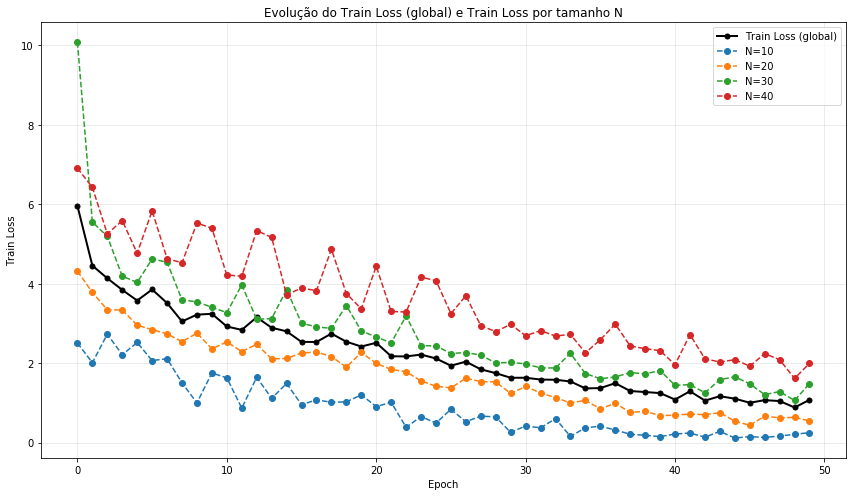

In [50]:

plot_training_losses(history)

# Load saved checkpoint

In [52]:
if notebook_mode==True:
    # Load checkpoint
    log_dir = f"./logs/{config.expt_name}/"
    if torch.cuda.is_available():
        checkpoint = torch.load(log_dir+"best_val_checkpoint.tar")
    else:
        checkpoint = torch.load(log_dir+"best_val_checkpoint.tar", map_location='cpu')
    # Load network state
    net.load_state_dict(checkpoint['model_state_dict'])
    # Load optimizer state
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # Load other training parameters
    epoch = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    val_loss = checkpoint['val_loss']
    for param_group in optimizer.param_groups:
        learning_rate = param_group['lr']
    print(f"Loaded checkpoint from epoch {epoch}")    

Loaded checkpoint from epoch 30


# Visualize model predictions

Class weights: [ 0.52631579 10.        ]
Predicted tour length: 5.434 (mean)
Groundtruth tour length: 5.164 (mean)
0  Invalid tour:  tensor([ 0, 14, 33, 12, 30,  9, 17, 34, 11,  8, 15, 22,  2, 31, 25, 21,  3, 24,
        16, 29, 36, 18, 27, 23,  1, 32, 20,  5,  7, 13,  4, 39, 35, 10, 28,  6,
        19, 26, 37, 38], device='cuda:0')
1  Invalid tour:  tensor([ 0, 24, 38, 32,  5, 25, 19, 27, 23,  2, 35, 20, 15,  1, 26, 13, 11, 28,
         8, 31, 12,  6,  3, 22, 17, 33, 37, 29,  9, 30,  4, 18, 39, 36, 10, 21,
        34,  7, 14, 16], device='cuda:0')
2  Invalid tour:  tensor([ 0, 31,  5, 30,  4, 36, 19, 35, 18, 26,  3,  1, 34, 20, 27,  9, 10, 22,
        17, 14, 37, 38, 23, 16,  6, 13, 11,  2, 12, 21, 39,  7, 24, 15, 33, 32,
        28,  8, 25, 29], device='cuda:0')
3  Invalid tour:  tensor([ 0, 21, 15, 25,  4,  5, 34, 19,  7, 22, 27, 31, 36, 26, 35, 12, 37, 30,
        23, 39,  1, 29, 13,  8,  9, 11, 14, 33, 18, 38,  6, 28, 17,  2,  3, 10,
        20, 32, 16, 24], device='cuda:0')
4  In

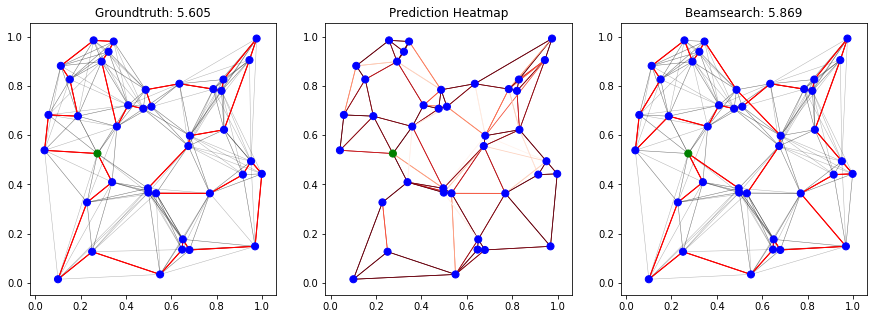

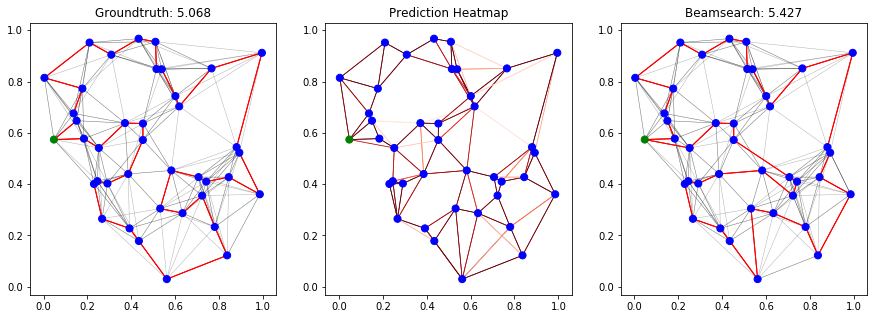

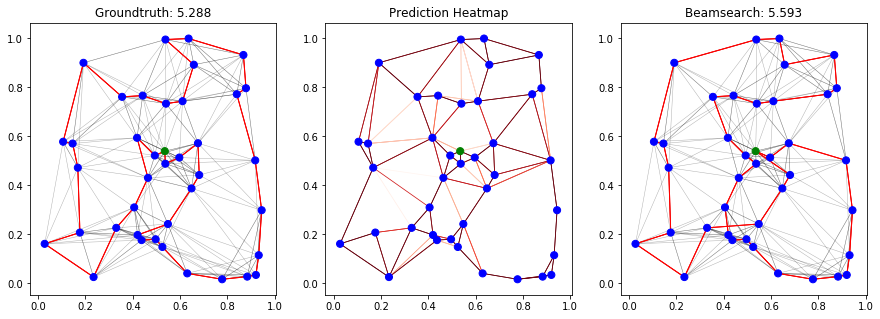

In [ ]:
if notebook_mode==True:
    # Set evaluation mode
    net.eval()
    
    batch_size = config.batch_size
    num_nodes = config.num_nodes
    knn_ratio = config.knn_ratio
    beam_size = config.beam_size
    test_filepath = config.test_filepath
    dataset = iter(VariableTSPReader(test_filepath, batch_size,  knn_ratio=config.knn_ratio,metric=config.metric))
    batch = next(dataset)

    N = batch.nodes.shape[1]

    with torch.no_grad():
        # Convert batch to torch Variables
        x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
        x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
        x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
        x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
        y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
        y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)
        
        # Compute class weights
        edge_labels = y_edges.cpu().numpy().flatten()
        edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
        print("Class weights: {}".format(edge_cw))
        
        # Forward pass
        y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
        loss = loss.mean()
        
        # Get batch beamsearch tour prediction
        bs_nodes = beamsearch_tour_nodes_shortest(
            y_preds, x_edges_values, beam_size, batch_size, N, dtypeFloat, dtypeLong, probs_type='logits')

        #bs_nodes = beamsearch_tour_nodes(
        #    y_preds, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')

        # Compute mean tour length
        pred_tour_len = mean_tour_len_nodes(x_edges_values, bs_nodes)
        gt_tour_len = np.mean(batch.tour_len)
        print("Predicted tour length: {:.3f} (mean)\nGroundtruth tour length: {:.3f} (mean)".format(pred_tour_len, gt_tour_len))

        # Sanity check
        for idx, nodes in enumerate(bs_nodes):
            if not is_valid_tour(nodes, num_nodes):
                print(idx, " Invalid tour: ", nodes)

        # Plot prediction visualizations
        plot_predictions_beamsearch(x_nodes_coord, x_edges, x_edges_values, y_edges, y_preds, bs_nodes, num_plots=3)

## Metrics

In [ ]:
def evaluate_full_testset_per_graph(net, config):
    net.eval()

    batch_size = config.batch_size
    beam_size = config.beam_size
    test_filepath = config.test_filepath
    knn_ratio = config.knn_ratio

    dataset = VariableTSPReader(test_filepath, batch_size, knn_ratio=knn_ratio, metric=config.metric)
    iterator = iter(dataset)

    # armazenar métricas por grafo
    all_pred_lengths = []
    all_gt_lengths = []
    all_gaps = []
    all_losses = []
    all_sizes = []   # N de cada grafo

    with torch.no_grad():
        for _ in range(dataset.max_iter):
            try:
                batch = next(iterator)
            except StopIteration:
                break

            B = batch.nodes.shape[0]
            N = batch.nodes.shape[1]

            # tensores
            x_edges = torch.LongTensor(batch.edges).type(dtypeLong)
            x_edges_values = torch.FloatTensor(batch.edges_values).type(dtypeFloat)
            x_nodes = torch.LongTensor(batch.nodes).type(dtypeLong)
            x_nodes_coord = torch.FloatTensor(batch.nodes_coord).type(dtypeFloat)
            y_edges = torch.LongTensor(batch.edges_target).type(dtypeLong)

            # class weights
            edge_labels = y_edges.cpu().numpy().flatten()
            edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)

            # forward
            y_preds, loss = net.forward(
                x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw
            )
            loss = loss.mean().item()  # ESCALAR

            # beamsearch: retorna uma lista de tours (tuplas de nós)
            bs_nodes = beamsearch_tour_nodes_shortest(
                y_preds, x_edges_values, beam_size, B, N, dtypeFloat, dtypeLong, probs_type='logits'
            )

            # tour length por grafo pred
            pred_len_list = []
            for b in range(B):
                tour = bs_nodes[b]
                length = 0.0
                for i in range(len(tour)):
                    u = tour[i]
                    v = tour[(i + 1) % len(tour)]
                    length += float(x_edges_values[b, u, v])
                pred_len_list.append(length)

            # gt tour length por grafo
            gt_len_list = batch.tour_len.tolist()

            # gaps
            gap_list = [(p/g - 1.0) for p, g in zip(pred_len_list, gt_len_list)]

            # armazenar tudo
            all_pred_lengths.extend(pred_len_list)
            all_gt_lengths.extend(gt_len_list)
            all_gaps.extend(gap_list)
            all_losses.extend([loss] * B)
            all_sizes.extend([N] * B)

    # -------- agregação global --------
    global_results = {
        "mean_pred_tour_len": float(np.mean(all_pred_lengths)),
        "std_pred_tour_len": float(np.std(all_pred_lengths)),
        
        "mean_gt_tour_len": float(np.mean(all_gt_lengths)),
        "std_gt_tour_len": float(np.std(all_gt_lengths)),
        
        "mean_gap": float(np.mean(all_gaps)),
        "std_gap": float(np.std(all_gaps)),
        
        "mean_loss": float(np.mean(all_losses)),
        "std_loss": float(np.std(all_losses)),
        
        "num_graphs": len(all_pred_lengths)
    }

    # -------- agregação por N --------
    results_by_N = {}
    unique_N = sorted(set(all_sizes))
    for N in unique_N:
        idx = [i for i, x in enumerate(all_sizes) if x == N]

        pred = [all_pred_lengths[i] for i in idx]
        gt = [all_gt_lengths[i] for i in idx]
        gaps = [all_gaps[i] for i in idx]
        losses = [all_losses[i] for i in idx]

        results_by_N[N] = {
            "mean_pred_tour_len": float(np.mean(pred)),
            "std_pred_tour_len": float(np.std(pred)),
            
            "mean_gt_tour_len": float(np.mean(gt)),
            "std_gt_tour_len": float(np.std(gt)),
            
            "mean_gap": float(np.mean(gaps)),
            "std_gap": float(np.std(gaps)),
            
            "mean_loss": float(np.mean(losses)),
            "std_loss": float(np.std(losses)),
            
            "count": len(idx)
        }

    return global_results, results_by_N


In [55]:
global_results, results_by_N = evaluate_full_testset_per_graph(net, config)

In [56]:
global_results

{'mean_pred_tour_len': 4.149853841935854,
 'std_pred_tour_len': 1.0567533904664466,
 'mean_gt_tour_len': 4.049223364549691,
 'std_gt_tour_len': 0.9392114950968523,
 'mean_gap': 0.020159768378925153,
 'std_gap': 0.038235954534303805,
 'mean_loss': 3.8477713664372764,
 'std_loss': 0.953752517849083,
 'num_graphs': 360}

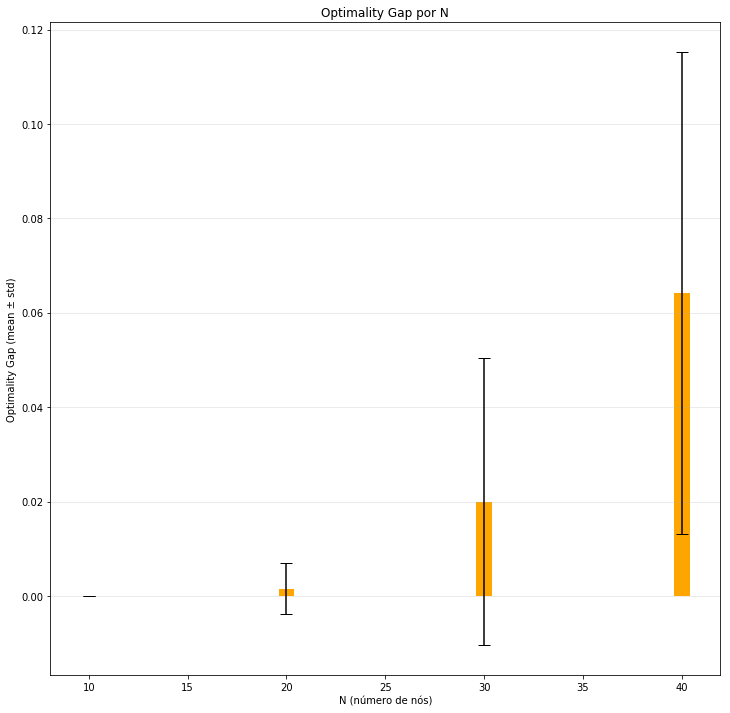

In [58]:
plot_results_by_N(results_by_N)